# ROUGE Scoring Against NIST and Wikipedia

Duplicating CrisisFACTS 2022 assessment via ROUGE

In [177]:
%matplotlib inline

In [178]:
import pandas as pd
import numpy as np
import json
import glob
import gzip
import os

import scipy.stats

import matplotlib.pyplot as plt

In [179]:
import wikipedia

In [180]:
from torchmetrics.text.rouge import ROUGEScore

## Get CrisisFACTS Event Metadata

In [181]:
event_df = pd.read_json("CrisisFACTs-2022to2023.topics.json", lines=False).set_index("eventID")

### Get Summaries from Wikipedia

In [182]:
def get_wiki_summary(url):
    
    if "wikipedia.org" not in url:
        return ""
    
    page_title = url.rpartition("/")[-1]
    print(url)
    page = wikipedia.page(title=page_title, auto_suggest=False)
    
    return page.summary

event_df["wiki.summary"] = event_df["url"].apply(get_wiki_summary)

https://en.wikipedia.org/wiki/Lilac_Fire
https://en.wikipedia.org/wiki/Cranston_Fire
https://en.wikipedia.org/wiki/Holy_Fire_(2018)
https://en.wikipedia.org/wiki/Hurricane_Florence
https://en.wikipedia.org/wiki/2018_Maryland_flood
https://en.wikipedia.org/wiki/Saddleridge_Fire
https://en.wikipedia.org/wiki/Hurricane_Laura
https://en.wikipedia.org/wiki/Hurricane_Sally
https://en.wikipedia.org/wiki/2020_Beirut_explosion
https://en.wikipedia.org/wiki/2020_Houston_explosion
https://en.wikipedia.org/wiki/Edenville_Dam#Dam_failure
https://en.wikipedia.org/wiki/Hurricane_Dorian
https://en.wikipedia.org/wiki/Kincade_Fire
https://en.wikipedia.org/wiki/2020_Easter_tornado_outbreak
https://en.wikipedia.org/wiki/Tornado_outbreak_of_April_22-23,_2020
https://en.wikipedia.org/wiki/Tornado_outbreak_of_March_2-3,_2020


### Get Summaries from Assessors

In [183]:
with open("final-annotated-facts-results.json", "r") as in_file:
    annotation_data = json.load(in_file)

In [184]:
event_fact_lists = {}

for req_id,req_data in annotation_data.items():
    event_id = req_id.rpartition("-")[0]
    local_fact_set = {f[0] for f in req_data["fact_list"] if f[2] == "USEFUL_FACT"}
    
    with open("../00-createSummaries/collapsed-event-days/Collapsed-%s.json" % req_id) as in_file:
        local_fact_data = json.load(in_file)
        
    local_fact_text = [
        fact["fact_text"] for fact in local_fact_data 
        if fact["collapsed_fact_id"] in local_fact_set
    ]
    
    local_fact_list = event_fact_lists.get(event_id, [])
    local_fact_list = local_fact_list + local_fact_text
    event_fact_lists[event_id] = local_fact_list

In [185]:
event_df["nist.summary"] = [". ".join(event_fact_lists[event_id]).replace("..", ".") for event_id in event_df.index]


## Save the Summaries

In [186]:
event_df.to_json("CrisisFACTs-2022to2023.topics.withSummaries.json")

In [187]:
rouge = ROUGEScore(
    use_stemmer=True,
    rouge_keys=("rouge2",)
)

In [188]:
TOP_K = 32

In [189]:
all_req_ids = list(annotation_data.keys())

In [190]:
submission_metrics = {}

for f in glob.glob("submissions/*.gz"):
    
    this_run_id = f.partition("/")[-1].replace(".gz", "")
    print(f, "-->", this_run_id)
    
    this_run_event_request_facts = {k:[] for k in all_req_ids}
    with gzip.open(f, "r") as in_file:
        for line_ in in_file:
            line = line_.decode("utf8")
            
            entry = json.loads(line)
            this_req_id = entry["requestID"]
            
            # We skip days where we have no relevant facts from assessors
            if this_req_id not in all_req_ids:
                continue
            
            this_run_event_request_facts[this_req_id].append(entry)
            
    local_event_summaries = {e_id:[] for e_id in event_df.index}
    for event_request,this_fact_list in this_run_event_request_facts.items():
        event_id = event_request.rpartition("-")[0]
        
        sorted_fact_list = sorted(this_fact_list, key=lambda v: v["importance"], reverse=True)
        this_day_summary = [this_top_fact["factText"] for this_top_fact in sorted_fact_list[:TOP_K]]
        
        local_event_summaries[event_id] = local_event_summaries[event_id] + this_day_summary
        

    wiki_dfs = []
    nist_dfs = []
    for event_id,event in event_df.iterrows():
        
        this_submitted_summary = local_event_summaries[event_id]
        if len(this_submitted_summary) == 0:
            continue

        this_summary_text = ". ".join(this_submitted_summary).replace("..", ".")
        print(event_id, len(this_summary_text))
        
        nist_summary = event["nist.summary"]
        wiki_summary = event["wiki.summary"]
        print(event_id, len(nist_summary))

        nist_metric_ = rouge(this_summary_text, nist_summary)
        wiki_metric_ = rouge(this_summary_text, wiki_summary)
        
        nist_metric = {
            "precision": nist_metric_["rouge2_precision"],
            "recall": nist_metric_["rouge2_recall"],
            "f1": nist_metric_["rouge2_fmeasure"],
        }
        
        wiki_metric = {
            "precision": wiki_metric_["rouge2_precision"],
            "recall": wiki_metric_["rouge2_recall"],
            "f1": wiki_metric_["rouge2_fmeasure"],
        }
        
        this_wiki_df = pd.DataFrame([{"metric":k, "value":v.item(), "event": event_id} for k,v in wiki_metric.items()])
        this_nist_df = pd.DataFrame([{"metric":k, "value":v.item(), "event": event_id} for k,v in nist_metric.items()])
        
        wiki_dfs.append(this_wiki_df)
        nist_dfs.append(this_nist_df)
        
    full_wiki_df = pd.concat(wiki_dfs)
    full_nist_df = pd.concat(nist_dfs)
    
    submission_metrics[this_run_id] = {
        "wiki": full_wiki_df,
        "nist": full_nist_df,
    }
    
    display(full_nist_df.groupby("metric")["value"].mean()) 



submissions\Thesis_Retriver.gz --> 
CrisisFACTS-010 9061
CrisisFACTS-010 19107
CrisisFACTS-013 17926
CrisisFACTS-013 56670


metric
f1           0.253757
precision    0.472949
recall       0.174862
Name: value, dtype: float64

In [191]:
all_runs = []
for k,v in submission_metrics.items():
    print(k)
    
    stackable = []
    for comparator,ldf in v.items():
        stackable_ldf = ldf.copy()
        stackable_ldf["target.summary"] = comparator

        stackable.append(stackable_ldf)

    this_run_df = pd.concat(stackable)
    this_run_df["run"] = k
    
    all_runs.append(this_run_df)
    this_run_df.to_csv("evaluation.output.rouge/%s.csv" % k, index=False)
    
all_runs_df = pd.concat(all_runs)
all_runs_df.to_csv("evaluation.output.rouge/all_runs.csv", index=False)

In [192]:
target_summaries = {}
for target in ["wiki", "nist"]:
    this_target_df = all_runs_df[all_runs_df["target.summary"] == target]
    
    index = []
    rows = []
    for run_name,group in this_target_df.groupby("run"):
        print(run_name)
        this_row = group.pivot(index="event", columns="metric", values="value").mean()
        rows.append(this_row)
        index.append(run_name)

    summary_df = pd.DataFrame(rows, index=index)[[
        "f1", 
    ]]

    final_df = summary_df.sort_values(by="f1", ascending=False)
    final_df.to_csv("evaluation.output.rouge/%s.summary.csv" % target)
    
    target_summaries[target] = final_df

In [193]:
rel2023_events = [
    'CrisisFACTS-009',
    'CrisisFACTS-010',
    'CrisisFACTS-011',
    'CrisisFACTS-012',
    'CrisisFACTS-013',
    'CrisisFACTS-014',
    'CrisisFACTS-015',
    'CrisisFACTS-016',
    'CrisisFACTS-017',
    'CrisisFACTS-018'

]

In [194]:
rows = []
for runtag,group in all_runs_df[all_runs_df["event"].isin(rel2023_events)].groupby("run"):
    print(runtag)
    t_map = {"run": runtag}
    for target,t_group in group.groupby("target.summary"):
        print("\t", target)
        
        if target == "wiki":
            t_group = t_group[~t_group["event"].isin(["CrisisFACTS-011", "CrisisFACTS-012"])]
        for metric,m_group in t_group.groupby("metric"):
            print("\t\t", metric, m_group["value"].mean())
            
            t_map["%s.%s" % (target,metric)] = m_group["value"].mean()
            
    rows.append(t_map)


	 nist
		 f1 0.2537574768066406
		 precision 0.47294874489307404
		 recall 0.17486192286014557
	 wiki
		 f1 0.03446448966860771
		 precision 0.01913389889523387
		 recall 0.22263260930776596


In [195]:
by_run_df = pd.DataFrame(rows).set_index("run")
by_run_df.to_csv("by_run.rouge.summary.csv")
by_run_df[["nist.f1", "wiki.f1"]]

,nist.f1,wiki.f1
run,,
,0.253757,0.034464


In [196]:
by_run_df[["nist.f1", "wiki.f1"]].corr()

,nist.f1,wiki.f1
nist.f1,NaN,NaN
wiki.f1,NaN,NaN


<Axes: xlabel='nist.f1', ylabel='wiki.f1'>

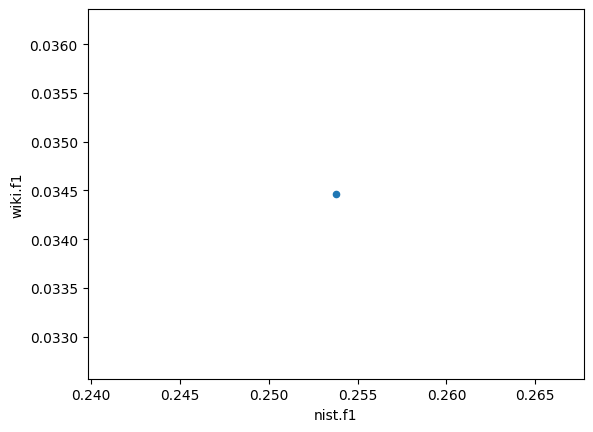

In [197]:
by_run_df[["nist.f1", "wiki.f1"]].plot.scatter(x="nist.f1", y="wiki.f1")

<Axes: ylabel='run'>

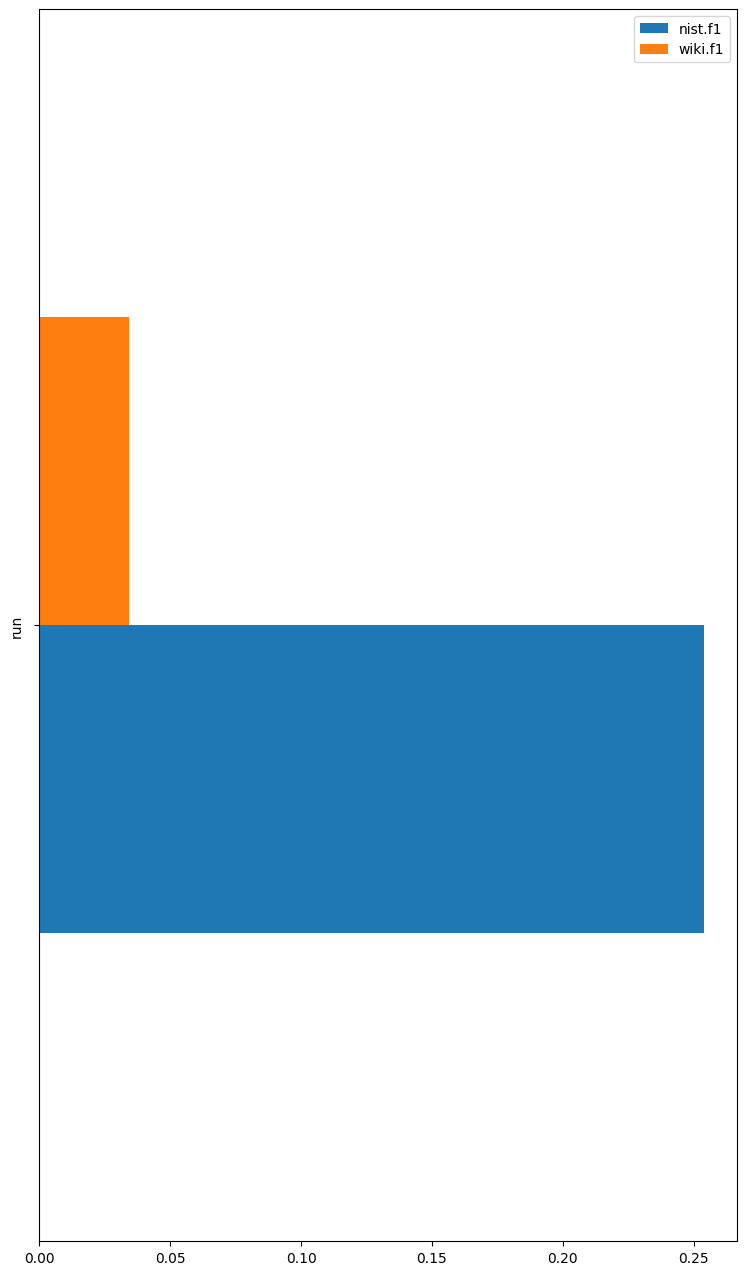

In [198]:
fig = plt.figure(figsize=(9,16))
ax = fig.add_subplot(1,1,1)

by_run_df[["nist.f1", "wiki.f1"]].sort_values(by="nist.f1").plot.barh(ax=ax)

In [199]:
by_run_df

,nist.f1,nist.precision,nist.recall,wiki.f1,wiki.precision,wiki.recall
run,,,,,,
,0.253757,0.472949,0.174862,0.034464,0.019134,0.222633


## By Day

In [200]:
rows = []
for event,group in all_runs_df[all_runs_df["event"].isin(rel2023_events)].groupby("event"):
    print(event)
    t_map = {"event": event}
    for target,t_group in group.groupby("target.summary"):
        print("\t", target)
        
        if target == "wiki":
            t_group = t_group[~t_group["event"].isin(["CrisisFACTS-011", "CrisisFACTS-012"])]
        for metric,m_group in t_group.groupby("metric"):
            print("\t\t", metric, m_group["value"].mean())
            
            t_map["%s.%s" % (target,metric)] = m_group["value"].mean()
            
    rows.append(t_map)

CrisisFACTS-010
	 nist
		 f1 0.23235228657722473
		 precision 0.3736654818058014
		 recall 0.16859345138072968
	 wiki
		 f1 0.04345127195119858
		 precision 0.024911031126976013
		 recall 0.16990290582180023
CrisisFACTS-013
	 nist
		 f1 0.2751626670360565
		 precision 0.5722320079803467
		 recall 0.18113039433956146
	 wiki
		 f1 0.025477707386016846
		 precision 0.013356766663491726
		 recall 0.2753623127937317


In [201]:
by_event_df = pd.DataFrame(rows).set_index("event")
by_event_df.to_csv("by_event.rouge.summary.csv")
by_event_df[["nist.f1", "wiki.f1"]]

,nist.f1,wiki.f1
event,,
CrisisFACTS-010,0.232352,0.043451
CrisisFACTS-013,0.275163,0.025478


<Axes: ylabel='event'>

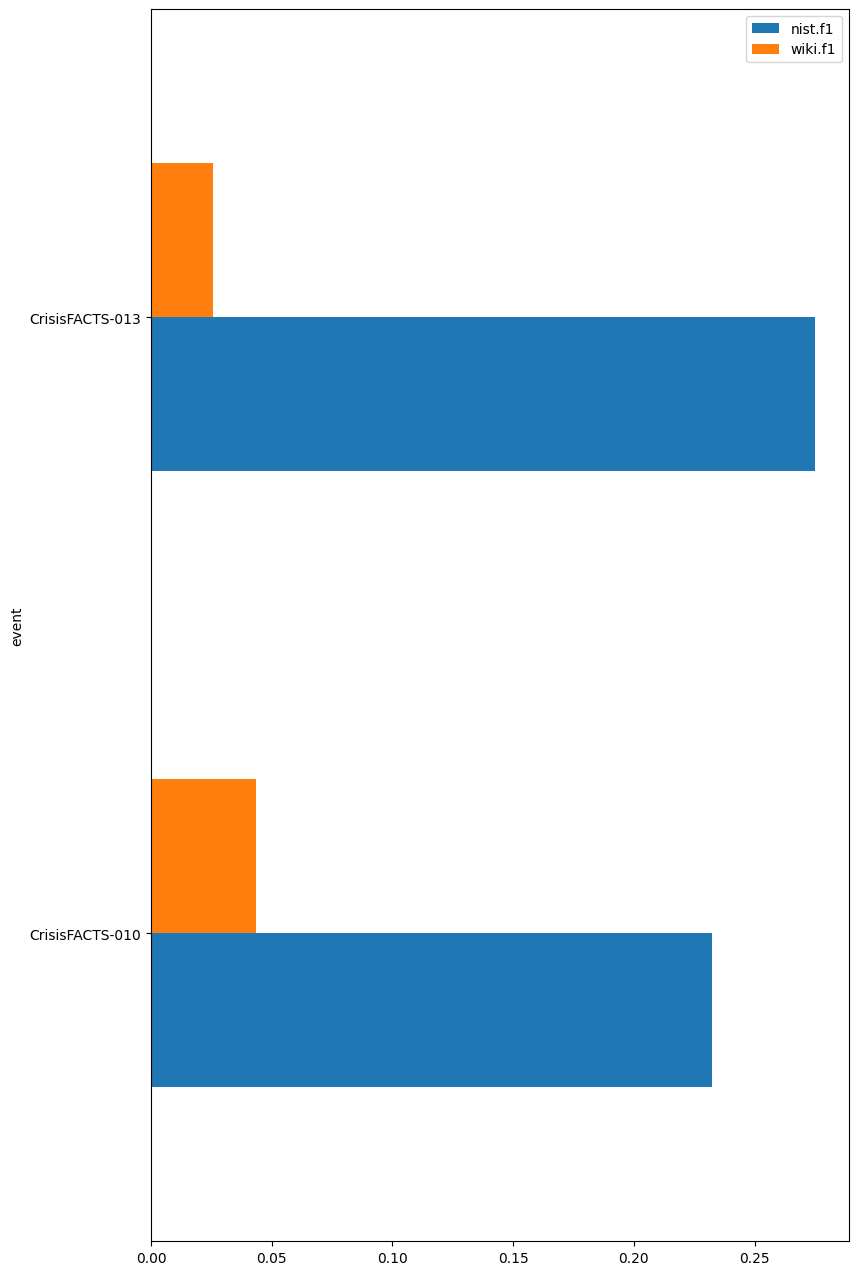

In [202]:
fig = plt.figure(figsize=(9,16))
ax = fig.add_subplot(1,1,1)

by_event_df[["nist.f1", "wiki.f1"]].plot.barh(ax=ax)

In [203]:
score_df = pd.read_csv("by_event.rouge.summary.csv", index_col=0)
print(score_df.groupby("event").mean().style.to_latex())

\begin{tabular}{lrrrrrr}
 & nist.f1 & nist.precision & nist.recall & wiki.f1 & wiki.precision & wiki.recall \\
event &  &  &  &  &  &  \\
CrisisFACTS-010 & 0.232352 & 0.373665 & 0.168593 & 0.043451 & 0.024911 & 0.169903 \\
CrisisFACTS-013 & 0.275163 & 0.572232 & 0.181130 & 0.025478 & 0.013357 & 0.275362 \\
\end{tabular}

